# Planar data classification with one hidden layer


**We will:**
- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation


In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

## 2 - Dataset ##

In [2]:
# Load a "flower" 2-class dataset into variables X and Y
X, Y = load_planar_dataset()

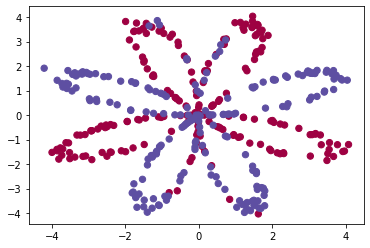

In [3]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [4]:
shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1]  # training set size

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('There are m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
There are m = 400 training examples!


## 3 - Simple Logistic Regression

In [5]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

/Users/vishweshwartyagi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


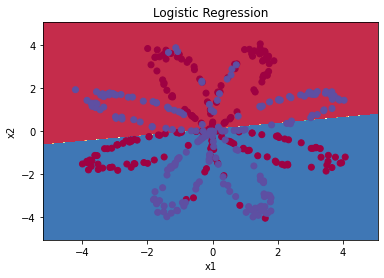

In [6]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y, LR_predictions) + np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Observation**: The dataset is not linearly separable, so logistic regression doesn't perform well as it can only produce a linear decision boundary. We'll use a neural network to produce a non-linear decision boundary.

## 4 - Neural Network model

**Neural Network with one hidden layer**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, the cost $J$ is calculated as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: Procedure:

    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

We'll build helper functions to compute steps 1-3 and then merge them into one function called `nn_model()`. Once we've built `nn_model()` and learnt the right parameters, we can make predictions on new data.

### 4.1 - Defining the neural network structure ####

**Here**:

    - n_0: the size of the input layer
    - n_1: the size of the first hidden layer  
    - n_2: the size of the output layer

In [7]:
# Layer sizes
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_0 -- the size of the input layer
    n_1 -- the size of the hidden layer
    n_2 -- the size of the output layer
    """
    
    Y = Y.T # keeping vectors as column vectors
    
    n_0 = X.shape[0] # size of input layer
    n_1 = 4 # size of hidden layer
    n_2 = Y.shape[1] # size of output layer
    
    return (n_0, n_1, n_2)

### 4.2 - Initialize the model's parameters ####

In [8]:
# Initialize parameters
def initialize_parameters(n_0, n_1, n_2):
    """
    Argument:
    n_0 -- size of the input layer
    n_1 -- size of the hidden layer
    n_2 -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    w1 -- weight matrix of shape (n_0, n_1)
                    b1 -- bias vector of shape (n_1, 1)
                    w2 -- weight matrix of shape (n_1, n_2)
                    b2 -- bias vector of shape (n_2, 1)
    """
    
    np.random.seed(2) # set up a seed so that output matches everytime
    
    w1 = np.random.randn(n_1, n_0).T * 0.01
    b1 = np.zeros(shape=(n_1, 1))
    w2 = np.random.randn(n_2, n_1).T * 0.01
    b2 = np.zeros(shape=(n_2, 1))
    
    assert (w1.shape == (n_0, n_1))
    assert (b1.shape == (n_1, 1))
    assert (w2.shape == (n_1, n_2))
    assert (b2.shape == (n_2, 1))
    
    parameters = {"w1": w1,
                  "b1": b1,
                  "w2": w2,
                  "b2": b2}
    
    return parameters

### 4.3 - The Loop ####

In [9]:
# forward_propagation
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_0, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    a2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "z1", "a1", "z2" and "a2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    # Implement Forward Propagation to calculate a2 (probabilities)
    z1 = np.dot(w1.T, X) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(w2.T, a1) + b2
    a2 = sigmoid(z2)
    
    cache = {"z1": z1,
             "a1": a1,
             "z2": z2,
             "a2": a2}
    
    return a2, cache

In [10]:
# compute_cost
def compute_cost(a2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    a2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters w1, b1, w2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    Y = Y.T # keeping vectors as column vectors
    m = Y.shape[0] # number of example
    
    # Retrieve w1 and w2 from parameters
    w1 = parameters['w1']
    w2 = parameters['w2']
    
    # Compute the cross-entropy cost
    cost = -(1./m) * ( np.dot(Y.T, np.log(a2.T)) + np.dot((1-Y).T, np.log(1-a2.T)) )[0, 0]

    assert(isinstance(cost, float))
    
    return cost

In [11]:
# backward_propagation
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "z1", "a1", "z2" and "a2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    Y = Y.T # keeping vectors as column vectors
    
    # Retrieve w1 and w2 from the dictionary "parameters".
    w1 = parameters['w1']
    w2 = parameters['w2']
        
    # Retrieve a1 and a2 from dictionary "cache".
    a1 = cache['a1']
    a2 = cache['a2']
    
    # Backward propagation: calculate dw1, db1, dw2, db2. 
    dw2 = -(1./m) * np.dot(a1, Y-a2.T)
    db2 = (-1./m) * np.sum( Y-a2.T )
    dw1 = -(1./m) * np.dot(w2, (Y-a2.T).T)
    dw1 = dw1 * ( 1-np.power(a1, 2) )
    dw1 = np.dot(dw1, X.T).T
    db1 = -(1./m) * np.dot(w2, (Y-a2.T).T)
    db1 = db1 * ( 1-np.power(a1, 2) )
    db1 = np.sum(db1, axis=1, keepdims=True)
    
    grads = {"dw1": dw1,
             "db1": db1,
             "dw2": dw2,
             "db2": db2}
    
    return grads

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [12]:
# update_parameters
def update_parameters(parameters, grads, learning_rate=1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    # Retrieve each gradient from the dictionary "grads"
    dw1 = grads['dw1']
    db1 = grads['db1']
    dw2 = grads['dw2']
    db2 = grads['db2']
    
    # Update rule for each parameter
    w1 = w1 - learning_rate * dw1
    b1 = b1 - learning_rate * db1
    w2 = w2 - learning_rate * dw2
    b2 = b2 - learning_rate * db2
    
    parameters = {"w1": w1,
                  "b1": b1,
                  "w2": w2,
                  "b2": b2}
    
    return parameters

### 4.4 - Integrate parts 4.1, 4.2 and 4.3 in nn_model() ####


In [13]:
# nn_model
def nn_model(X, Y, n_1, num_iterations=10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, m)
    Y -- labels of shape (1, m)
    n_1 -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_0 = layer_sizes(X, Y)[0]
    n_2 = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve w1, b1, w2, b2. 
    # Inputs: "n_0, n_1, n_2". Outputs = "w1, b1, w2, b2, parameters".
    parameters = initialize_parameters(n_0, n_1, n_2)
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "a2, cache".
        a2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "a2, Y, parameters". Outputs: "cost".
        cost = compute_cost(a2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    return parameters

### 4.5 Predictions

We use:

predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    

In [14]:
# predict
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_0, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    a2, cache = forward_propagation(X, parameters)
    predictions = a2 > .5 # threshold = .5
    predictions = predictions.astype(int)
    
    return predictions

**Time to run the model and see how it performs on a planar dataset** 

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219446
Cost after iteration 9000: 0.218605


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

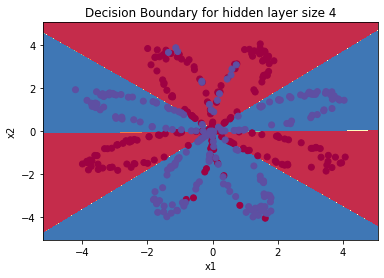

In [15]:
# Build a model with a n_1-dimensional hidden layer
parameters = nn_model(X, Y, n_1 = 4, num_iterations=10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [16]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 90%


**Observation:** Accuracy is really high compared to Logistic Regression. The model has learnt the leaf patterns of the flower! 

Now, we can try out with several hidden layer sizes.

### 4.6 - Tuning hidden layer size ###

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.0 %
Accuracy for 50 hidden units: 90.25 %


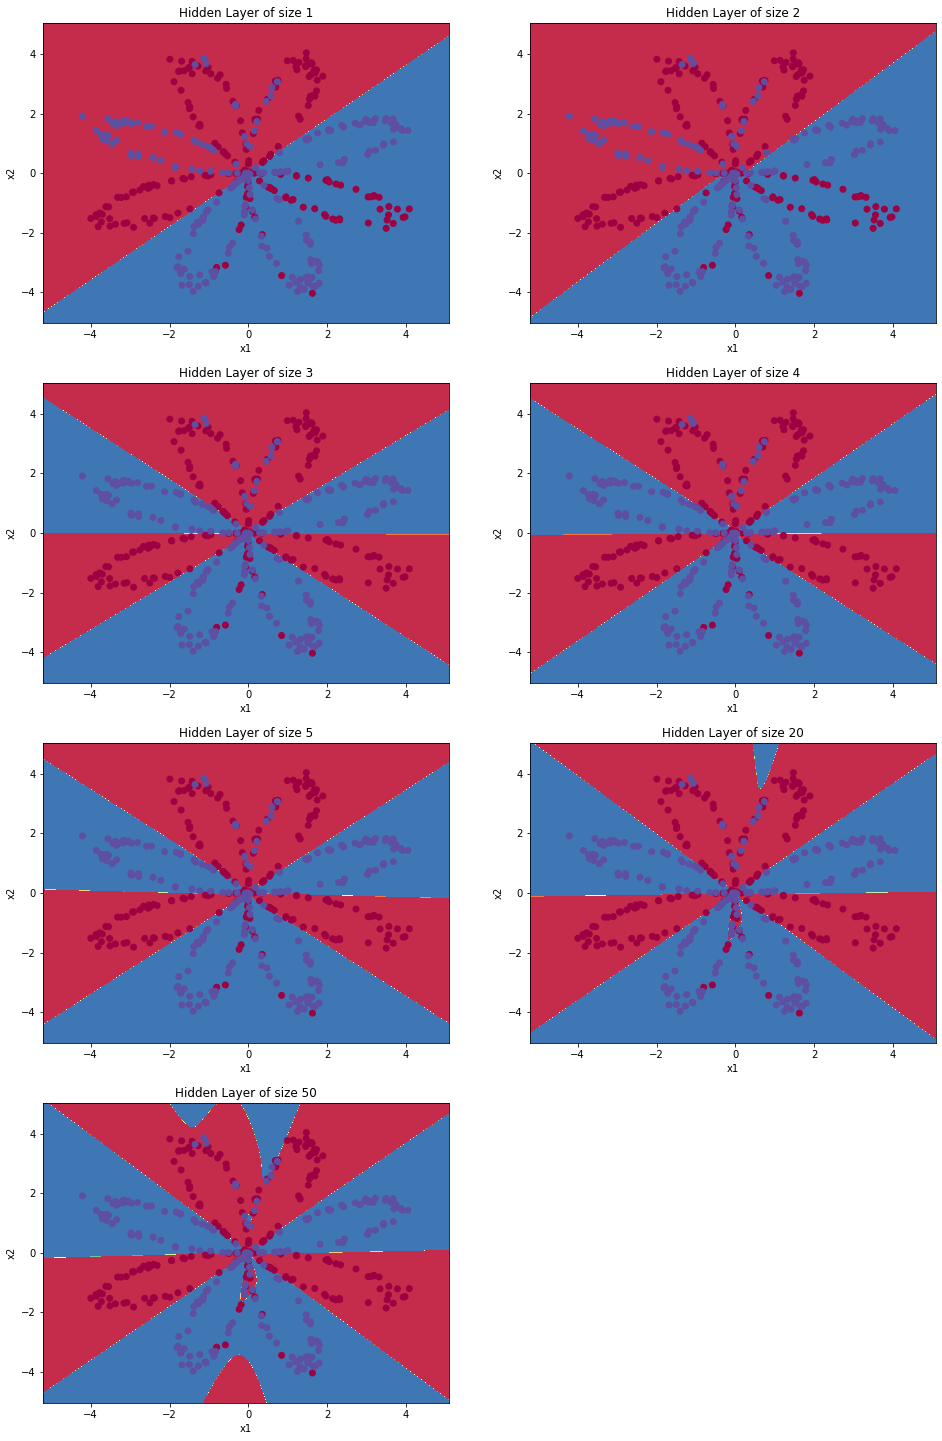

In [17]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_1 in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_1)
    parameters = nn_model(X, Y, n_1, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
    print ("Accuracy for {} hidden units: {} %".format(n_1, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticable overfitting.

## 5) Performance on other datasets

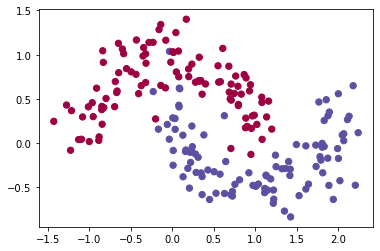

In [18]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y % 2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Cost after iteration 0: 0.692992
Cost after iteration 1000: 0.167137
Cost after iteration 2000: 0.069092
Cost after iteration 3000: 0.063716
Cost after iteration 4000: 0.061312
Cost after iteration 5000: 0.059669
Cost after iteration 6000: 0.058364
Cost after iteration 7000: 0.057279
Cost after iteration 8000: 0.056359
Cost after iteration 9000: 0.055569


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

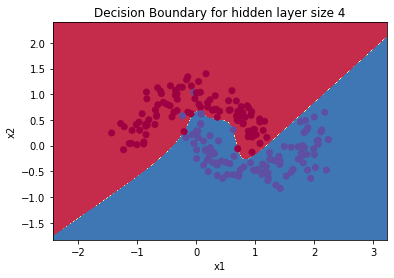

In [19]:
# Build a model with a n_1-dimensional hidden layer
parameters = nn_model(X, Y, n_1 = 4, num_iterations=10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [20]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 98%


Congrats on finishing this Programming Assignment!

Reference:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/